# Advanced NLP

- Working a Text-Based Data Science Problem using kaggle
- https://www.kaggle.com/c/whats-cooking

## Content of Notebook

1. Reading in and exploring the data
2. Feature engineering
3. Model evaluation using **`train_test_split`** and **`cross_val_score`**
4. Making predictions for new data
5. Searching for optimal tuning parameters using **`GridSearchCV`**
6. Extracting features from text using **`CountVectorizer`**
7. Chaining steps into a **`Pipeline`**

# Importing key Modules

In [1]:
# for Python 2: use print only as a function
from __future__ import print_function
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import learning_curve,GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn import metrics

#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 15, 12
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

## Part 1: Reading in and exploring the data

https://www.kaggle.com/c/whats-cooking

In [2]:
train = pd.read_json('../data/train.json')
train.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [3]:
train.shape

(39774, 3)

In [4]:
# count the number of null values in each column
train.isnull().sum()

id             0
cuisine        0
ingredients    0
dtype: int64

In [5]:
train.dtypes

id              int64
cuisine        object
ingredients    object
dtype: object

In [6]:
# select row 0, column 'ingredients'
train.ingredients[0]

['romaine lettuce',
 'black olives',
 'grape tomatoes',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo beans',
 'feta cheese crumbles']

In [7]:
train.loc[0, 'ingredients']

['romaine lettuce',
 'black olives',
 'grape tomatoes',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo beans',
 'feta cheese crumbles']

In [8]:
# ingredients are stored as a list of strings, not as a string
type(train.loc[0, 'ingredients'])

list

In [9]:
train.loc[0,"cuisine"]

'greek'

In [10]:
type(train.loc[0,"cuisine"])

str

In [11]:
# examine the class distribution
train.cuisine.value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

In [12]:
len(train.cuisine.value_counts())

20

In [13]:
train.cuisine.value_counts().shape

(20,)

## Part 2: Feature engineering

- Feature engineering is the process through which you create features that **don't natively exist** in the dataset.
- Your goal is to create features that contain the **signal** from the data (with respect to the response value), rather than the **noise**.

### Example: Number of ingredients

In [14]:
# count the number of ingredients in each recipe
train['num_ingredients'] = train.ingredients.apply(len)
train.head(2)

,id,cuisine,ingredients,num_ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11


In [15]:
# for each cuisine, calculate the mean number of ingredients
train.groupby('cuisine').num_ingredients.mean()

cuisine
brazilian        9.520343
british          9.708955
cajun_creole    12.617076
chinese         11.982791
filipino        10.000000
french           9.817838
greek           10.182128
indian          12.705961
irish            9.299850
italian          9.909033
jamaican        12.214829
japanese         9.735067
korean          11.284337
mexican         10.877446
moroccan        12.909866
russian         10.224949
southern_us      9.634954
spanish         10.423660
thai            12.545809
vietnamese      12.675152
Name: num_ingredients, dtype: float64

In [16]:
# for each cuisine, "describe" the number of ingredients (and unstack into a DataFrame)
train.groupby('cuisine').num_ingredients.describe()

,count,mean,std,min,25%,50%,75%,max
cuisine,,,,,,,,
brazilian,467.0,9.520343,5.555139,2.0,5.0,9.0,13.0,59.0
british,804.0,9.708955,4.165011,2.0,7.0,9.0,12.0,30.0
cajun_creole,1546.0,12.617076,4.611601,2.0,9.0,12.0,16.0,31.0
chinese,2673.0,11.982791,4.042125,2.0,9.0,12.0,14.0,38.0
filipino,755.0,10.000000,3.855135,2.0,7.0,10.0,12.0,38.0
french,2646.0,9.817838,4.144744,1.0,7.0,9.0,12.0,31.0
greek,1175.0,10.182128,3.729461,1.0,7.0,10.0,12.0,27.0
indian,3003.0,12.705961,5.016806,1.0,9.0,12.0,16.0,49.0
irish,667.0,9.299850,3.700505,2.0,7.0,9.0,12.0,27.0


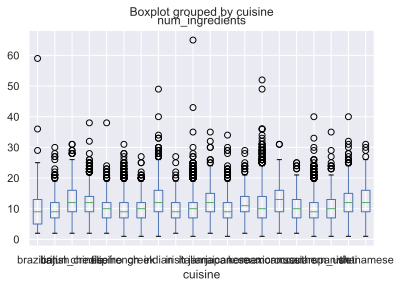

In [17]:
# box plot of number ingredients for each cuisine
train.boxplot('num_ingredients', by='cuisine')

### Example: Mean length of ingredient names

In [18]:
sample_recipe = train.loc[3, 'ingredients']
print(sample_recipe)

['water', 'vegetable oil', 'wheat', 'salt']


In [19]:
# define a function that calculates the mean string length from a list of strings
def mean_string_length(list_of_strings):
    return np.mean([len(string) for string in list_of_strings])

In [20]:
mean_string_length(sample_recipe)

6.75

In [21]:
# calculate the mean ingredient length for each recipe (two different ways)
train['ingredient_length'] = train.ingredients.apply(mean_string_length)
# using lambda function
train['ingredient_length'] = train.ingredients.apply(lambda x: np.mean([len(item) for item in x]))
train.head()

,id,cuisine,ingredients,num_ingredients,ingredient_length
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9,12.000000
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11,10.090909
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,10.333333
3,22213,indian,"[water, vegetable oil, wheat, salt]",4,6.750000
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",20,10.100000


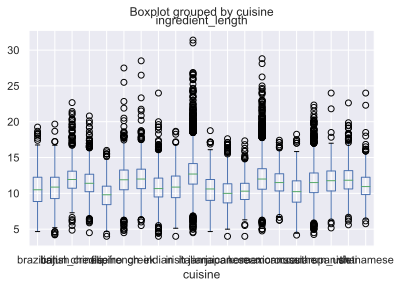

In [22]:
# box plot of mean ingredient length for each cuisine
train.boxplot('ingredient_length', by='cuisine')

**In quick way, we can do all above using make_features function**

In [23]:
# define a function that accepts a DataFrame and adds new features
def make_features(df):
    df['num_ingredients'] = df.ingredients.apply(len)
    df['ingredient_length'] = df.ingredients.apply(lambda x: np.mean([len(item) for item in x]))
    return df

In [24]:
# check that the function works
train = make_features(pd.read_json('../data/train.json'))
train.head()

,id,cuisine,ingredients,num_ingredients,ingredient_length
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9,12.000000
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11,10.090909
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,10.333333
3,22213,indian,"[water, vegetable oil, wheat, salt]",4,6.750000
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",20,10.100000


In [25]:
train.shape

(39774, 5)

## Part 3: Model evaluation using `train_test_split` and `cross_val_score`

- The motivation for model evaluation is that you need a way to **choose between models** (different model types, tuning parameters, and features).
- You use a model evaluation procedure to estimate how well a model will **generalize** to out-of-sample data.
- This requires a model evaluation metric to **quantify** a model's performance.

In [26]:
# define X and y
feature_cols = ['num_ingredients', 'ingredient_length']
X = train[feature_cols]
y = train.cuisine

In [27]:
print(X.shape)
print(y.shape)

(39774, 2)
(39774,)


In [28]:
# note: response values are strings (not numbers)
y.values

array(['greek', 'southern_us', 'filipino', ..., 'irish', 'chinese',
       'mexican'], dtype=object)

[KNeighborsClassifier documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [29]:
# use KNN with K=100
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=100)

### Train/test split

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [31]:
print(X_train.shape)
print(X_test.shape)

(29830, 2)
(9944, 2)


In [32]:
# make class predictions for the testing set
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)

In [33]:
# check the classification accuracy of KNN's predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.21932823813354788

### K-fold cross-validation

- Train/test split is **faster and more flexible**
- Cross-validation provides a **more accurate** estimate of out-of-sample performance

In [34]:
# evaluate with 5-fold cross-validation (using X instead of X_train)
from sklearn.model_selection import cross_val_score
cross_val_score(knn, X, y, cv=5, scoring='accuracy').mean()

0.21591924749538957

### Null model

- For **classification** problems, the null model always predicts the most frequent class from the training data.
- For **regression problems**, the null model always predicts the mean of the response value from the training data.
- It can be a useful **baseline model** against which your model is measured.

In [35]:
# calculate the null accuracy
y_test.value_counts().head(1) / y_test.shape

italian    0.199216
Name: cuisine, dtype: float64

[DummyClassifier documentation](http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html)

In [36]:
# use DummyClassifier instead
from sklearn.dummy import DummyClassifier
dumb = DummyClassifier(strategy='most_frequent')
dumb.fit(X_train, y_train)
y_pred_class = dumb.predict(X_test)
metrics.accuracy_score(y_test, y_pred_class)

0.1992156074014481

## Part 4: Making predictions for new data

new data is test data i.e out of sample. It contains ingridients but, no information of Cuisine. we shall predict this response values

In [37]:
# read in test.json and add the additional features
new = make_features(pd.read_json('../data/test.json'))
new.head()

,id,ingredients,num_ingredients,ingredient_length
0,18009,"[baking powder, eggs, all-purpose flour, raisi...",6,9.333333
1,28583,"[sugar, egg yolks, corn starch, cream of tarta...",11,10.272727
2,41580,"[sausage links, fennel bulb, fronds, olive oil...",6,9.666667
3,29752,"[meat cuts, file powder, smoked sausage, okra,...",21,12.000000
4,35687,"[ground black pepper, salt, sausage casings, l...",8,13.000000


In [38]:
new.shape

(9944, 4)

In [39]:
# create a DataFrame of the relevant columns from the new data
X_new = new[feature_cols]
X_new.head()

,num_ingredients,ingredient_length
0,6,9.333333
1,11,10.272727
2,6,9.666667
3,21,12.000000
4,8,13.000000


In [40]:
X_new.shape

(9944, 2)

In [41]:
# train KNN on ALL of the training data (using X instead of X_train)
%time knn.fit(X, y)

CPU times: user 122 ms, sys: 1.45 ms, total: 123 ms
Wall time: 123 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                     weights='uniform')

In [42]:
# make class predictions for the new data
new_pred_class_knn = knn.predict(X_new)
new_pred_class_knn

array(['mexican', 'southern_us', 'mexican', ..., 'italian', 'mexican',
       'mexican'], dtype=object)

In [43]:
new_pred_class_knn.shape

(9944,)

In [44]:
# create a DataFrame that only contains the IDs and predicted classes for the new data
pd.DataFrame({'id':new.id, 'cuisine':new_pred_class_knn}).set_index('id').head()

,cuisine
id,
18009,mexican
28583,southern_us
41580,mexican
29752,mexican
35687,italian


In [45]:
# create a submission file from that DataFrame (score: 0.21742)
pd.DataFrame({'id':new.id, 'cuisine':new_pred_class_knn}).set_index('id').to_csv('submission1.csv')

## Part 5: Searching for optimal tuning parameters using `GridSearchCV`

In [46]:
# reminder of the cross-validated accuracy of KNN with K=100
knn = KNeighborsClassifier(n_neighbors=100)
cross_val_score(knn, X, y, cv=5, scoring='accuracy').mean()

0.21591924749538957

[GridSearchCV documentation](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html)

In [47]:
from sklearn.model_selection import GridSearchCV

In [48]:
# define a "parameter grid" in which the key is the parameter and the value is a list of options to try
param_grid = {}
param_grid['n_neighbors'] = [100, 200]
param_grid

{'n_neighbors': [100, 200]}

In [49]:
# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

In [50]:
# run the grid search
%time grid.fit(X, y)

CPU times: user 13.5 s, sys: 363 ms, total: 13.9 s
Wall time: 4.99 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=100, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None, param_grid={'n_neighbors': [100, 200]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [51]:
grid.best_score_

0.2194901191733293

In [52]:
grid.best_params_

{'n_neighbors': 200}

In [53]:
grid.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=200, p=2,
                     weights='uniform')

In [54]:
# examine the scores for each parameter option
grid.cv_results_

{'mean_fit_time': array([0.08339438, 0.08121381]),
 'std_fit_time': array([0.01065178, 0.00602979]),
 'mean_score_time': array([0.30074425, 0.42394037]),
 'std_score_time': array([0.00423299, 0.00576757]),
 'param_n_neighbors': masked_array(data=[100, 200],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 100}, {'n_neighbors': 200}],
 'split0_test_score': array([0.21828686, 0.21740769]),
 'split1_test_score': array([0.21588339, 0.22204071]),
 'split2_test_score': array([0.21644042, 0.22083962]),
 'split3_test_score': array([0.21292919, 0.21959502]),
 'split4_test_score': array([0.21605637, 0.21756638]),
 'mean_test_score': array([0.21591995, 0.21949012]),
 'std_test_score': array([0.00172271, 0.00180987]),
 'rank_test_score': array([2, 1], dtype=int32)}

**mean_test_score': array([0.21591995, 0.21949012]),**


**'std_test_score': array([0.00172271, 0.00180987]),**

### Change values in n_neighbors

In [55]:
# try K=200 to 1000 (by 200)
param_grid = {}
param_grid['n_neighbors'] = list(range(200, 1001, 200))
param_grid

{'n_neighbors': [200, 400, 600, 800, 1000]}

In [56]:
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

In [57]:
# time the grid search using an IPython "magic function"
%time grid.fit(X, y)

CPU times: user 46.3 s, sys: 3.41 s, total: 49.7 s
Wall time: 25 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=100, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [200, 400, 600, 800, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [58]:
grid.best_params_

{'n_neighbors': 800}

In [59]:
grid.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=800, p=2,
                     weights='uniform')

In [60]:
# examine the scores for each parameter option
grid.cv_results_

{'mean_fit_time': array([0.08043399, 0.08080878, 0.07722864, 0.08101296, 0.08035164]),
 'std_fit_time': array([0.00324404, 0.00515622, 0.00117156, 0.00216676, 0.00154768]),
 'mean_score_time': array([0.42018461, 0.65982962, 0.89109998, 1.13092599, 1.36925669]),
 'std_score_time': array([0.00927324, 0.01175323, 0.00660588, 0.01366183, 0.01850874]),
 'param_n_neighbors': masked_array(data=[200, 400, 600, 800, 1000],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 200},
  {'n_neighbors': 400},
  {'n_neighbors': 600},
  {'n_neighbors': 800},
  {'n_neighbors': 1000}],
 'split0_test_score': array([0.21740769, 0.21878925, 0.22205476, 0.22167797, 0.22167797]),
 'split1_test_score': array([0.22204071, 0.22606182, 0.22392561, 0.22518221, 0.22292033]),
 'split2_test_score': array([0.22083962, 0.21857717, 0.22360483, 0.2253645 , 0.22448467]),
 'split3_test_score': array([0.21959502, 0.2200981 , 0.2213558 , 0.22

###  examine the scores for each parameter option

In [61]:
results = pd.DataFrame(grid.cv_results_)
results[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.219490,0.001810,{'n_neighbors': 200}
1,0.219943,0.003311,{'n_neighbors': 400}
2,0.222130,0.001541,{'n_neighbors': 600}
3,0.222960,0.001906,{'n_neighbors': 800}
4,0.221929,0.001693,{'n_neighbors': 1000}


In [62]:
# extract only the mean scores
grid_mean_scores = results['mean_test_score']
grid_mean_scores

0    0.219490
1    0.219943
2    0.222130
3    0.222960
4    0.221929
Name: mean_test_score, dtype: float64

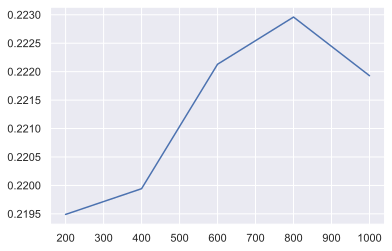

In [63]:
plt.plot(list(range(200, 1001, 200)), grid_mean_scores)

In [64]:
# print the single best score and parameters that produced that score
print(grid.best_score_)
print(grid.best_params_)

0.22295972243173934
{'n_neighbors': 800}


## Part 6: Extracting features from text

- using `CountVectorizer`

In [65]:
train.head(2)

,id,cuisine,ingredients,num_ingredients,ingredient_length
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9,12.000000
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11,10.090909


In [66]:
# reminder: ingredients are stored as a list of strings, not as a string
train.loc[0, 'ingredients']

['romaine lettuce',
 'black olives',
 'grape tomatoes',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo beans',
 'feta cheese crumbles']

In [67]:
type(train.ingredients[0])

list

**We need to convert this list into string**

In [68]:
# convert each list of ingredients into a string
train.ingredients.astype(str)[0]

"['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']"

In [77]:
train.ingredients_str=train.ingredients.astype(str)

In [78]:
type(train.ingredients_str)

pandas.core.series.Series

**Apply string function to whole dataframe**

In [79]:
# update make_features to create a new column 'ingredients_str'
def make_features(df):
    df['num_ingredients'] = df.ingredients.apply(len)
    df['ingredient_length'] = df.ingredients.apply(lambda x: np.mean([len(item) for item in x]))
    df['ingredients_str'] = df.ingredients.astype(str)
    return df

In [80]:
# run make_features and check that it worked
train = make_features(pd.read_json('../data/train.json'))
train.loc[0, 'ingredients_str']

"['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']"

In [81]:
train.dtypes

id                     int64
cuisine               object
ingredients           object
num_ingredients        int64
ingredient_length    float64
ingredients_str       object
dtype: object

In [82]:
train.head(2)

,id,cuisine,ingredients,num_ingredients,ingredient_length,ingredients_str
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9,12.000000,"['romaine lettuce', 'black olives', 'grape tom..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11,10.090909,"['plain flour', 'ground pepper', 'salt', 'toma..."


In [83]:
# define X(as string one now) and y
X = train.ingredients_str
y = train.cuisine

In [84]:
print(X.shape)
print(y.shape)

(39774,)
(39774,)


In [85]:
# import and instantiate CountVectorizer (with default parameters)
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [86]:
# create a document-term matrix from all of the training data
X_dtm = vect.fit_transform(X)
X_dtm.shape

(39774, 3010)

It means that we have '3010' unique tokens

In [87]:
# examine the features that were created
print(vect.get_feature_names()[0:100])

['00', '10', '100', '14', '15', '25', '33', '40', '43', '95', '96', 'abalone', 'abbamele', 'absinthe', 'abura', 'acai', 'accent', 'accompaniment', 'achiote', 'acid', 'acini', 'ackee', 'acorn', 'acting', 'activ', 'active', 'added', 'adobo', 'adzuki', 'agar', 'agave', 'age', 'aged', 'ahi', 'aioli', 'ajinomoto', 'ajwain', 'aka', 'alaskan', 'albacore', 'alcohol', 'ale', 'aleppo', 'alexia', 'alfalfa', 'alfredo', 'all', 'allspice', 'almond', 'almondmilk', 'almonds', 'aloe', 'alphabet', 'alum', 'amaranth', 'amarena', 'amaretti', 'amaretto', 'amba', 'amber', 'amberjack', 'amchur', 'america', 'american', 'aminos', 'ammonium', 'amontillado', 'ampalaya', 'an', 'anaheim', 'anasazi', 'ancho', 'anchovies', 'anchovy', 'and', 'andouille', 'anejo', 'angel', 'anglaise', 'angled', 'angostura', 'angus', 'anise', 'anisette', 'anjou', 'annatto', 'any', 'aonori', 'apple', 'apples', 'applesauce', 'applewood', 'apricot', 'apricots', 'aquavit', 'arak', 'arame', 'arbol', 'arborio', 'arctic']


**we can use ngram(1,2). But we get two token for each and more noise**

In [88]:
# replace the regex pattern that is used for tokenization
vect = CountVectorizer(token_pattern=r"'([a-z ]+)'")
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern="'([a-z ]+)'", tokenizer=None,
                vocabulary=None)

In [89]:
X_dtm = vect.fit_transform(X)
X_dtm.shape

(39774, 6250)

In [90]:
type(X_dtm)

scipy.sparse.csr.csr_matrix

In [91]:
# examine the features that were created
print(vect.get_feature_names()[0:100])

['a taste of thai rice noodles', 'abalone', 'abbamele', 'absinthe', 'abura age', 'acai juice', 'accent', 'accent seasoning', 'accompaniment', 'achiote', 'achiote paste', 'achiote powder', 'acini di pepe', 'ackee', 'acorn squash', 'active dry yeast', 'adobo', 'adobo all purpose seasoning', 'adobo sauce', 'adobo seasoning', 'adobo style seasoning', 'adzuki beans', 'agar', 'agar agar flakes', 'agave nectar', 'agave tequila', 'aged balsamic vinegar', 'aged cheddar cheese', 'aged gouda', 'aged manchego cheese', 'ahi', 'ahi tuna steaks', 'aioli', 'ajinomoto', 'ajwain', 'aka miso', 'alaskan king crab legs', 'alaskan king salmon', 'albacore', 'albacore tuna in water', 'alcohol', 'ale', 'aleppo', 'aleppo pepper', 'alexia waffle fries', 'alfalfa sprouts', 'alfredo sauce', 'alfredo sauce mix', 'all beef hot dogs', 'all potato purpos', 'all purpose seasoning', 'all purpose unbleached flour', 'allspice', 'allspice berries', 'almond butter', 'almond extract', 'almond filling', 'almond flour', 'almon

In [92]:
# import and instantiate Multinomial Naive Bayes (with the default parameters)
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [93]:
# slightly improper cross-validation
cross_val_score(nb, X_dtm, y, cv=5, scoring='accuracy').mean()

0.7301267156198039

**Why is this improper cross-validation?**

- Normally, we split the data into training and testing sets **before** creating the document-term matrix. But since **`cross_val_score`** does the splitting for you, we passed it the feature matrix (**`X_dtm`**) rather than the raw text (**`X`**).
- However, that does not appropriately simulate the real world, in which your out-of-sample data will contain **features that were not seen** during model training.

**What's the solution?**

- We need a way to pass **`X`** (not **`X_dtm`**) to **`cross_val_score`**, and have the feature creation (via **`CountVectorizer`**) occur **within each fold** of cross-validation.
- We will do this by using a **`Pipeline`**.

## Part 7: Chaining steps into a `Pipeline`

In [94]:
# examine the numeric columns of the training data
train.describe()

,id,num_ingredients,ingredient_length
count,39774.000000,39774.000000,39774.000000
mean,24849.536959,10.767713,11.733187
std,14360.035505,4.428978,2.364183
min,0.000000,1.000000,4.000000
25%,12398.250000,8.000000,10.200000
50%,24887.000000,10.000000,11.625000
75%,37328.500000,13.000000,13.117647
max,49717.000000,65.000000,31.400000


[Imputer documentation](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html)

In [95]:
# define '1' as a missing value and impute a replacement using the median
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values=1, strategy='median')

/opt/miniconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


[make_pipeline documentation](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html)

In [96]:
# create a pipeline of missing value imputation and KNN
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(imp, knn)

In [97]:
# examine the pipeline steps
pipe.steps

[('imputer',
  Imputer(axis=0, copy=True, missing_values=1, strategy='median', verbose=0)),
 ('kneighborsclassifier',
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                       metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                       weights='uniform'))]

[Pipeline documentation](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

In [98]:
# alternative method for creating the identical pipeline
from sklearn.pipeline import Pipeline
pipe = Pipeline([('imputer', imp), ('kneighborsclassifier', knn)])

In [99]:
# fit and predict using the entire pipeline
pipe.fit(X_train, y_train)
y_pred_class = pipe.predict(X_test)
metrics.accuracy_score(y_test, y_pred_class)

0.22043443282381336

### Using a `Pipeline` for proper cross-validation

In [100]:
# create a pipeline of vectorization and Naive Bayes
pipe = make_pipeline(vect, nb)
pipe.steps

[('countvectorizer',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                  lowercase=True, max_df=1.0, max_features=None, min_df=1,
                  ngram_range=(1, 1), preprocessor=None, stop_words=None,
                  strip_accents=None, token_pattern="'([a-z ]+)'", tokenizer=None,
                  vocabulary=None)),
 ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

We can now pass **`X`** (instead of **`X_dtm`**) to **`cross_val_score`**, and the vectorization will occur **within each fold** of cross-validation.

In [101]:
# X is just a Series of strings
X.head()

0    ['romaine lettuce', 'black olives', 'grape tom...
1    ['plain flour', 'ground pepper', 'salt', 'toma...
2    ['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...
3          ['water', 'vegetable oil', 'wheat', 'salt']
4    ['black pepper', 'shallots', 'cornflour', 'cay...
Name: ingredients_str, dtype: object

In [102]:
# cross-validate the entire pipeline
cross_val_score(pipe, X, y, cv=5, scoring='accuracy').mean()

0.7322884933790151

### Making predictions using a `Pipeline`

In [103]:
# fit the pipeline (rather than just the model)
pipe.fit(X, y)

Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern="'([a-z ]+)'", tokenizer=None,
                                 vocabulary=None)),
                ('multinomialnb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [104]:
# read in test.json and add the additional features
new = make_features(pd.read_json('../data/test.json'))

In [105]:
# define X_new as a Series of strings
X_new = new.ingredients_str

In [106]:
# use the pipeline to make predictions for the new data
new_pred_class_pipe = pipe.predict(X_new)

In [107]:
# create a submission file (score: 0.73663)
df_submission=pd.DataFrame({'id':new.id, 'cuisine':new_pred_class_pipe}).set_index('id').to_csv('submission2.csv')